In [7]:

# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm

### Step one

In [8]:
# تنظیم نمایش بهتر نمودارها و اعداد فارسی
# Set plot style and Persian numbers
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

In [9]:
df = pd.read_csv('pima_cleaned.csv')

In [12]:
print("اطلاعات اولیه دیتاست:")
print(f"تعداد نمونه‌ها: {df.shape[0]}")
print(f"تعداد ویژگی‌ها: {df.shape[1] - 1}")
print("\nبررسی پنج نمونه اول:")
print(df.head())

اطلاعات اولیه دیتاست:
تعداد نمونه‌ها: 768
تعداد ویژگی‌ها: 8

بررسی پنج نمونه اول:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.352941  0.670968       0.489796       0.304348  0.019832  0.314928   
1     0.058824  0.264516       0.428571       0.239130  0.019832  0.171779   
2     0.470588  0.896774       0.408163       0.173913  0.019832  0.104294   
3     0.058824  0.290323       0.428571       0.173913  0.096154  0.202454   
4     0.000000  0.600000       0.163265       0.304348  0.185096  0.509202   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.234415  0.483333        1  
1                  0.116567  0.166667        0  
2                  0.253629  0.183333        1  
3                  0.038002  0.000000        0  
4                  0.943638  0.200000        1  


In [14]:
# جدا کردن ویژگی هدف (دیابت) از بقیه ویژگی‌ها
# Separating the target feature (diabetes) from other features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

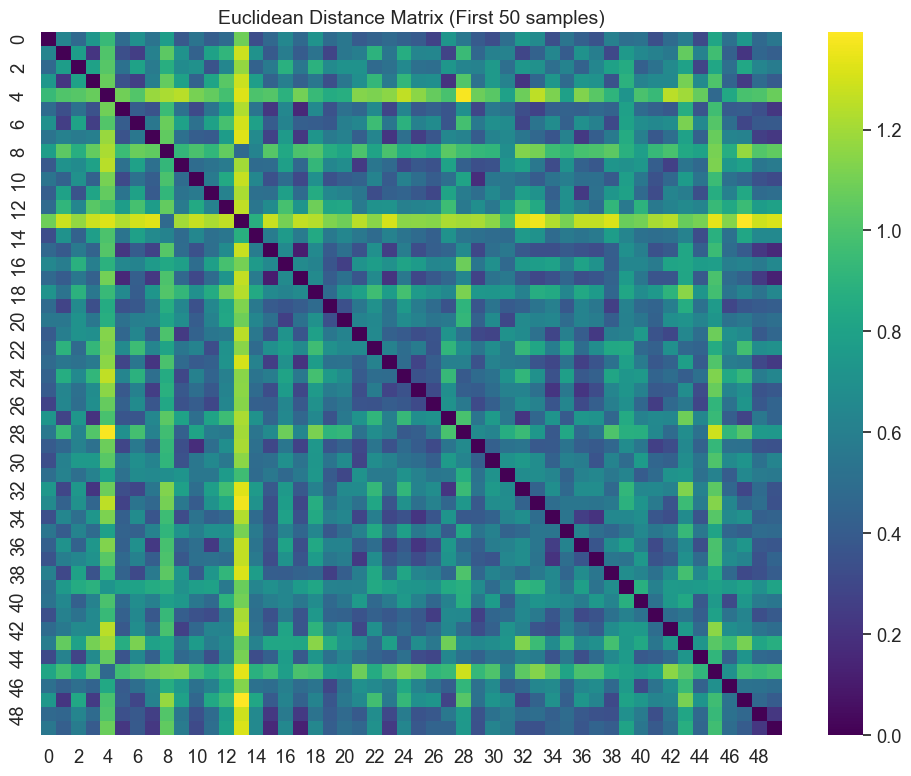

In [22]:
# محاسبه ماتریس فاصله اقلیدسی بین تمام نمونه‌ها
# Calculate Euclidean distance matrix between all samples
distance_matrix = pairwise_distances(X, metric='euclidean')

# نمایش ماتریس فاصله با نقشه حرارتی
# Display the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix[:50, :50], cmap='viridis')
plt.title('Euclidean Distance Matrix (First 50 samples)', fontsize=14)
plt.tight_layout()

### Step two - Hierarchical Clustering (AGNES)

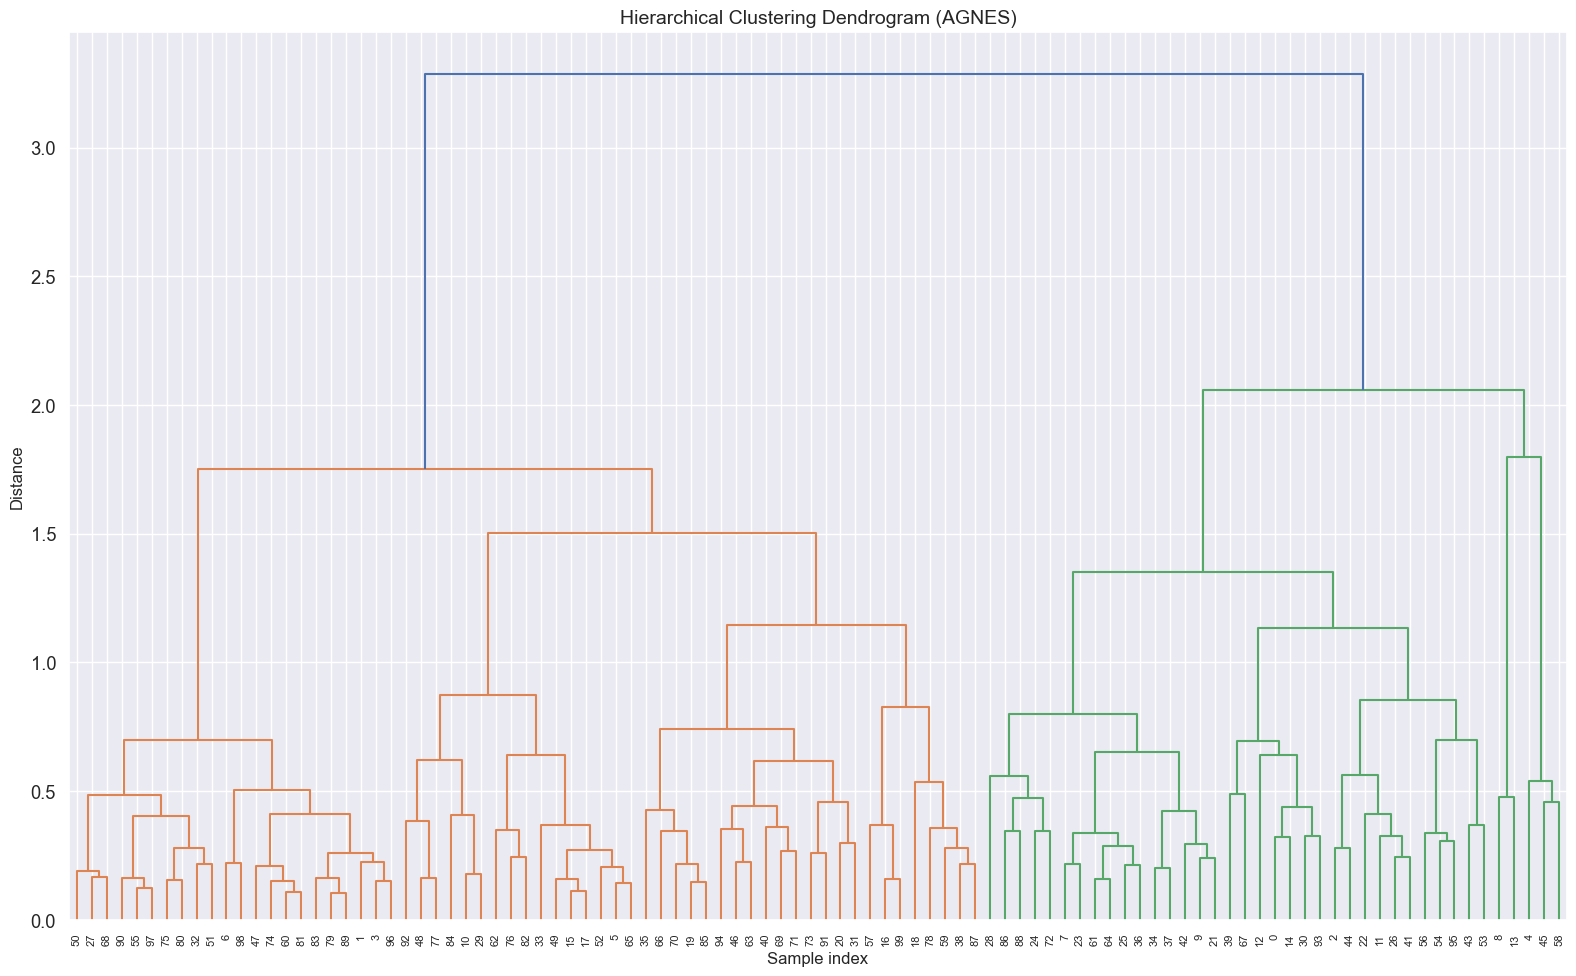

In [27]:
# رسم دندروگرام برای مشاهده ساختار سلسله‌مراتبی (با نمونه محدود برای وضوح بیشتر)
# Draw dendrogram to observe hierarchical structure (with limited samples for clarity)
sample_size = 100  # برای وضوح بیشتر، تعداد محدودی نمونه انتخاب می‌کنیم
sampled_X = X[:sample_size]

# محاسبه ماتریس لینکیج با روش Ward
# Calculate linkage matrix using Ward method
Z = linkage(sampled_X, 'ward')

plt.figure(figsize=(16, 10))
plt.title('Hierarchical Clustering Dendrogram (AGNES)', fontsize=14)
plt.xlabel('Sample index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
dendrogram(
    Z,
    leaf_rotation=90.,  # چرخش برچسب‌های برگ
    leaf_font_size=8.,  # اندازه فونت برچسب‌های برگ
)
plt.tight_layout()

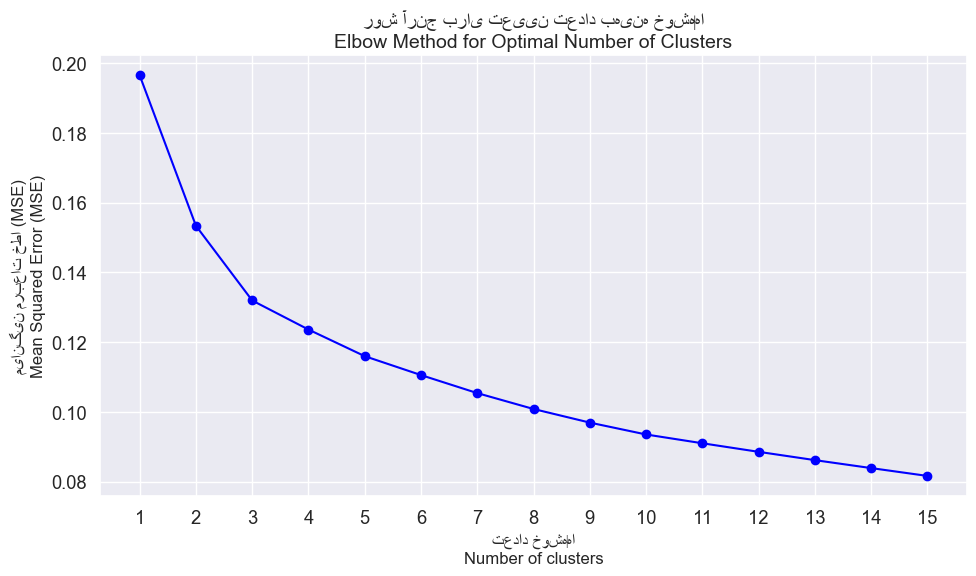

In [30]:
# محاسبه MSE برای تعیین تعداد بهینه خوشه‌ها
# Calculate MSE to determine optimal number of clusters
max_clusters = 15
mse_values = []

# محاسبه MSE برای تعداد مختلف خوشه‌ها
# Calculate MSE for different numbers of clusters
for n_clusters in range(1, max_clusters + 1):
    # اگر تعداد خوشه‌ها برابر با 1 باشد، میانگین کل داده‌ها را به عنوان مرکز در نظر می‌گیریم
    # If number of clusters is 1, we consider the mean of all data as the center
    if n_clusters == 1:
        centers = np.mean(X, axis=0).reshape(1, -1)
        cluster_labels = np.zeros(X.shape[0], dtype=int)
    else:
        # اجرای الگوریتم خوشه‌بندی سلسله‌مراتبی
        # Run hierarchical clustering algorithm
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        cluster_labels = clustering.fit_predict(X)
        
        # محاسبه مراکز خوشه‌ها
        # Calculate cluster centers
        centers = np.zeros((n_clusters, X.shape[1]))
        for i in range(n_clusters):
            centers[i] = np.mean(X[cluster_labels == i], axis=0)
    
    # محاسبه MSE برای هر نمونه نسبت به مرکز خوشه خودش
    # Calculate MSE for each sample relative to its cluster center
    mse = 0
    for i in range(X.shape[0]):
        cluster_idx = cluster_labels[i]
        mse += np.sum((X[i] - centers[cluster_idx]) ** 2)
    
    mse /= X.shape[0]  # میانگین خطای مربعات
    mse_values.append(mse)

# رسم نمودار MSE برای تعیین تعداد بهینه خوشه‌ها (روش آرنج یا Elbow method)
# Plot MSE to determine optimal number of clusters (Elbow method)
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), mse_values, 'o-', color='blue')
plt.title('روش آرنج برای تعیین تعداد بهینه خوشه‌ها\nElbow Method for Optimal Number of Clusters', fontsize=14)
plt.xlabel('تعداد خوشه‌ها\nNumber of clusters', fontsize=12)
plt.ylabel('میانگین مربعات خطا (MSE)\nMean Squared Error (MSE)', fontsize=12)
plt.grid(True)
plt.xticks(range(1, max_clusters + 1))
plt.tight_layout()

In [31]:
# تعیین تعداد بهینه خوشه‌ها با استفاده از تفاضل دوم MSE
# Determine optimal number of clusters using second derivative of MSE
second_derivative = np.diff(np.diff(mse_values))
k_optimal = np.argmax(second_derivative) + 2  # +2 برای جبران دو بار diff و شروع از 1

print(f"تعداد بهینه خوشه‌ها براساس روش آرنج: {k_optimal}")
print(f"Optimal number of clusters based on Elbow method: {k_optimal}")

تعداد بهینه خوشه‌ها براساس روش آرنج: 2
Optimal number of clusters based on Elbow method: 2
